# Assignment - 9

In [ ]:
import pandas as pd

In [1]:
train_dataframe = pd.read_csv('train.csv', dtype={'image_id': str})
print(train_dataframe.head())
category_attributes_dataframe = pd.read_parquet('category_attributes.parquet')
print(category_attributes_dataframe.head())

   id image_id     Category  len      attr_1 attr_2   attr_3   attr_4  \
0   0   000000  Men Tshirts    5     default  round  printed  default   
1   1   000001  Men Tshirts    5  multicolor   polo    solid    solid   
2   2   000002  Men Tshirts    5     default   polo    solid    solid   
3   3   000003  Men Tshirts    5  multicolor   polo    solid    solid   
4   4   000004  Men Tshirts    5  multicolor   polo    solid    solid   

          attr_5 attr_6 attr_7 attr_8 attr_9 attr_10  
0  short sleeves    NaN    NaN    NaN    NaN     NaN  
1  short sleeves    NaN    NaN    NaN    NaN     NaN  
2  short sleeves    NaN    NaN    NaN    NaN     NaN  
3  short sleeves    NaN    NaN    NaN    NaN     NaN  
4  short sleeves    NaN    NaN    NaN    NaN     NaN  
              Category  No_of_attribute  \
0          Men Tshirts                5   
1               Sarees               10   
2               Kurtis                9   
3        Women Tshirts                8   
4  Women Tops & 

In [2]:
consolidated_dataframe = pd.merge(train_dataframe, category_attributes_dataframe, on='Category', how='inner')
print(consolidated_dataframe.head())

   id image_id     Category  len      attr_1 attr_2   attr_3   attr_4  \
0   0   000000  Men Tshirts    5     default  round  printed  default   
1   1   000001  Men Tshirts    5  multicolor   polo    solid    solid   
2   2   000002  Men Tshirts    5     default   polo    solid    solid   
3   3   000003  Men Tshirts    5  multicolor   polo    solid    solid   
4   4   000004  Men Tshirts    5  multicolor   polo    solid    solid   

          attr_5 attr_6 attr_7 attr_8 attr_9 attr_10  No_of_attribute  \
0  short sleeves    NaN    NaN    NaN    NaN     NaN                5   
1  short sleeves    NaN    NaN    NaN    NaN     NaN                5   
2  short sleeves    NaN    NaN    NaN    NaN     NaN                5   
3  short sleeves    NaN    NaN    NaN    NaN     NaN                5   
4  short sleeves    NaN    NaN    NaN    NaN     NaN                5   

                                      Attribute_list  
0  [color, neck, pattern, print_or_pattern_type, ...  
1  [color, n

In [4]:
categories = ['Men Tshirts', 'Sarees', 'Kurtis', 'Women Tshirts', 'Women Tops & Tunics']
attributes = {
    'Men Tshirts': ['attr_1', 'attr_3'],
    'Sarees': ['attr_2', 'attr_8'],
    'Kurtis': ['attr_3', 'attr_8'],
    'Women Tshirts': ['attr_1', 'attr_2'],
    'Women Tops & Tunics': ['attr_1', 'attr_5']
}

In [ ]:
baskets = {}

In [5]:
for category in categories:
    for attribute in attributes[category]:
        samples = df[(df['Category'] == category) & (df[attribute].notna())].sample(100, replace=True)
        baskets[(category, attribute)] = samples

In [6]:
from PIL import Image
import os
import pandas as pd

image_directory = "train_images/"

def load_image(image_identifier):
    image_path = os.path.join(image_directory, f"{image_identifier}.jpg")
    return Image.open(image_path)

train_dataframe = pd.read_csv('train.csv', dtype={'image_id': str})
print(train_dataframe.head())

category_attributes_dataframe = pd.read_parquet('category_attributes.parquet')
print(category_attributes_dataframe.head())

# Merge dataframes on 'Category'
consolidated_dataframe = pd.merge(train_dataframe, category_attributes_dataframe, on='Category', how='inner')
print(consolidated_dataframe.head())

# Initialize a dictionary to store resized images for each (category, attribute)
resized_images_dict = {}

for (category, attribute), samples in baskets.items():
    # Load and resize images for the current basket
    images = [load_image(image_id) for image_id in samples['image_id']]
    resized_images_dict[(category, attribute)] = [img.resize((128, 128)) for img in images]  # Resize to 128x128

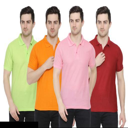

In [21]:
resized_images_dict[('Men Tshirts', 'attr_1')][46]

In [7]:
import numpy as np

def extract_color_histogram(image):
    # Convert image to numpy array and calculate histogram for each color channel
    image_array = np.array(image)
    
    histogram_red = np.histogram(image_array[:, :, 0], bins=256, range=(0, 256))[0]
    histogram_green = np.histogram(image_array[:, :, 1], bins=256, range=(0, 256))[0]
    histogram_blue = np.histogram(image_array[:, :, 2], bins=256, range=(0, 256))[0]
    
    return np.concatenate([histogram_red, histogram_green, histogram_blue])


In [8]:
# Extract feature arrays for manifold learning
for (category, attribute), images in resized_images_dict.items():
    feature_list = [extract_color_histogram(img) for img in images]
    feature_array = np.array(feature_list)

In [10]:
from matplotlib import offsetbox
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, TSNE
import numpy as np

In [15]:
# Define the plot_components function to display images on the manifold
def plot_components(data, model, images=None, ax=None, thumb_fraction=0.05, cmap='gray', zoom=0.3):
    ax = ax or plt.gca()  # Use provided axis or get current axis
    projected_data = model.fit_transform(data)  # Fit model and transform data
    ax.plot(projected_data[:, 0], projected_data[:, 1], '.k')  # Plot points as black dots

    if images is not None:
        min_distance_squared = (thumb_fraction * max(projected_data.max(0) - projected_data.min(0))) ** 2
        shown_images = np.array([2 * projected_data.max(0)])
        for i in range(data.shape[0]):
            distance = np.sum((projected_data[i] - shown_images) ** 2, axis=1)
            if np.min(distance) < min_distance_squared:
                continue  # Skip too-close points
            shown_images = np.vstack([shown_images, projected_data[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=zoom),
                projected_data[i]
            )
            ax.add_artist(imagebox)
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap mig

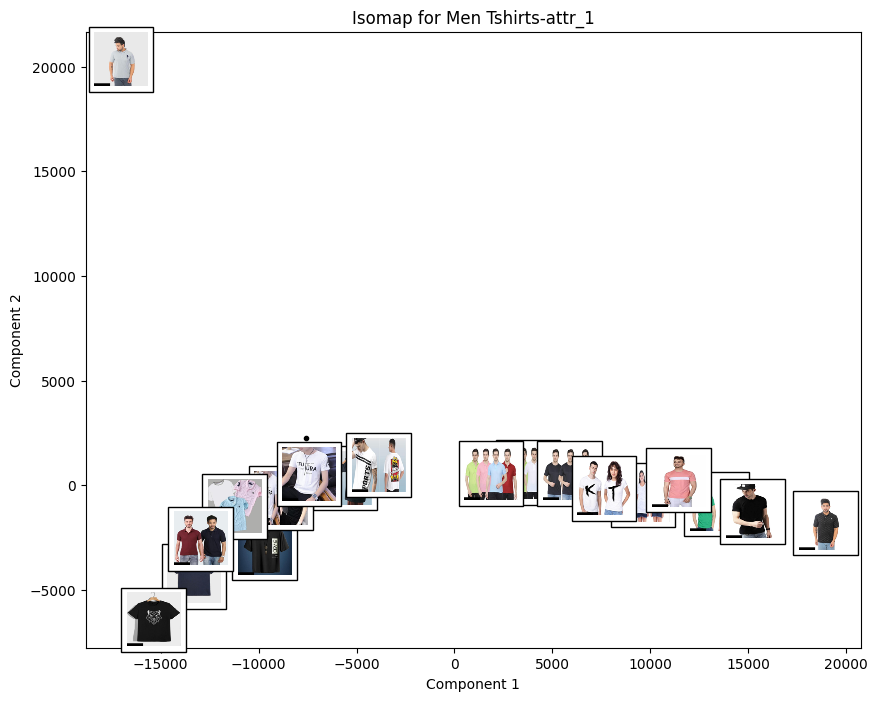

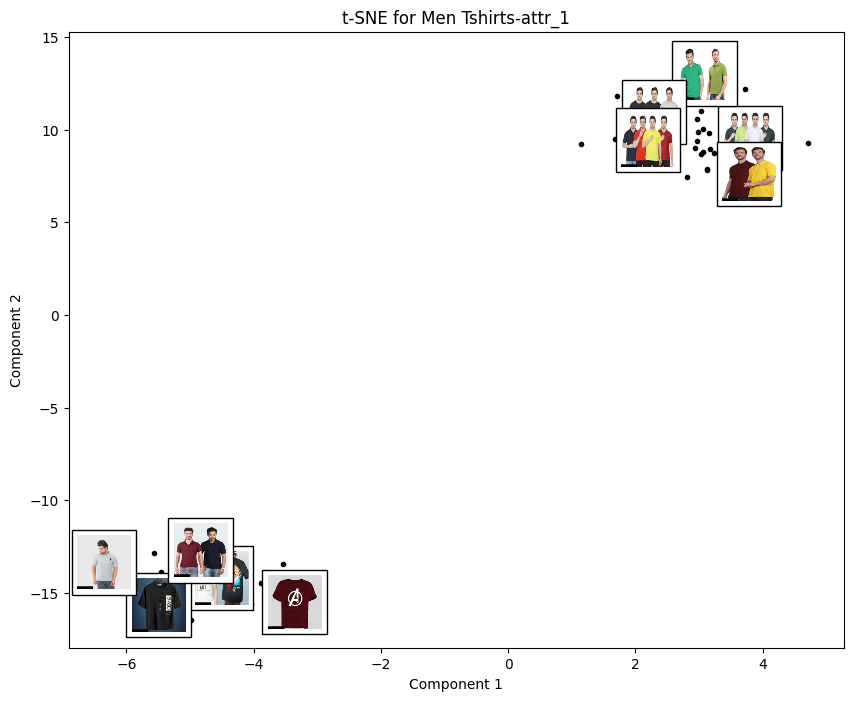

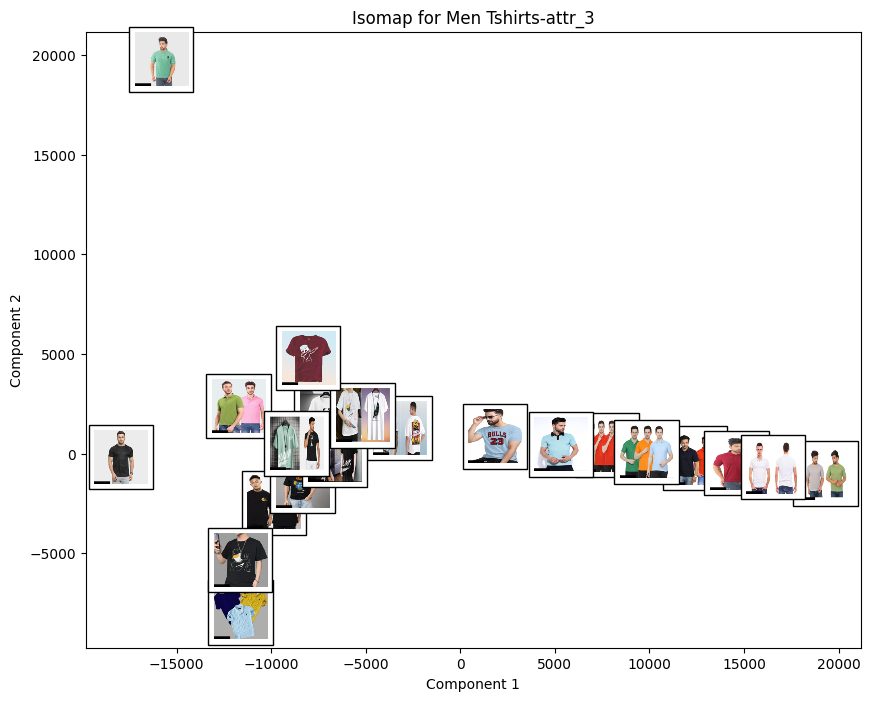

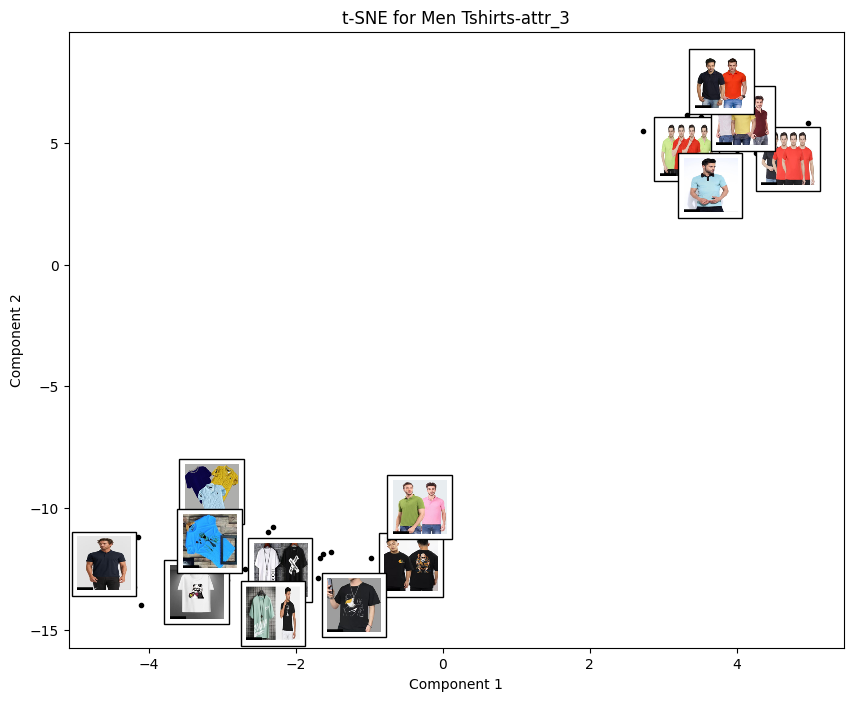

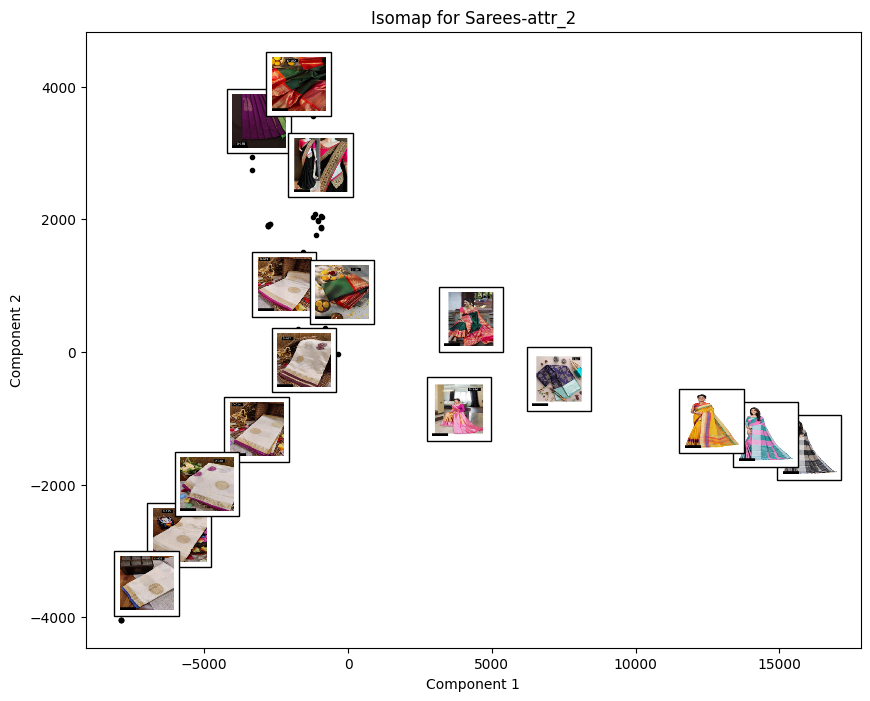

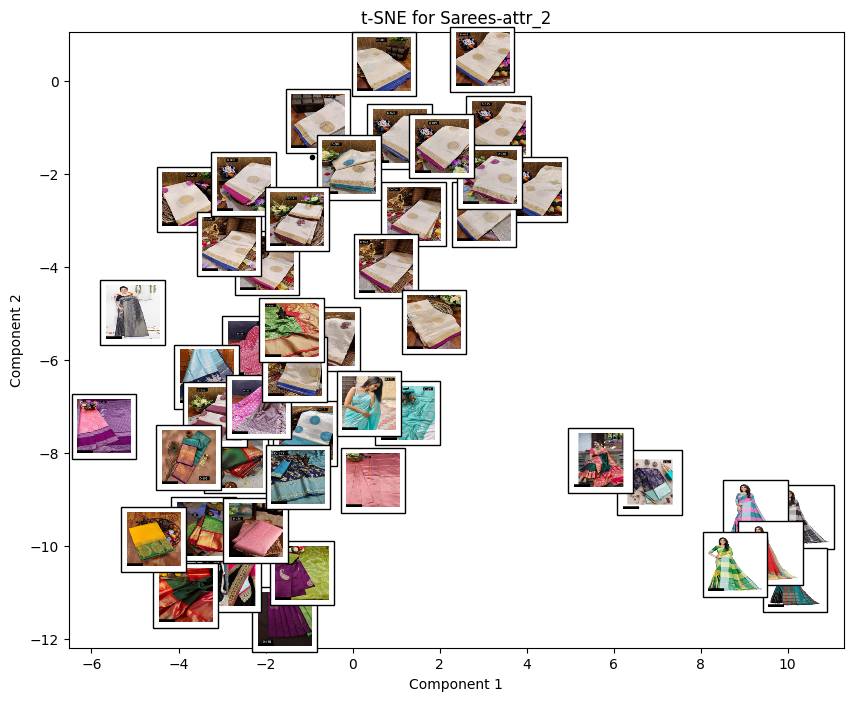

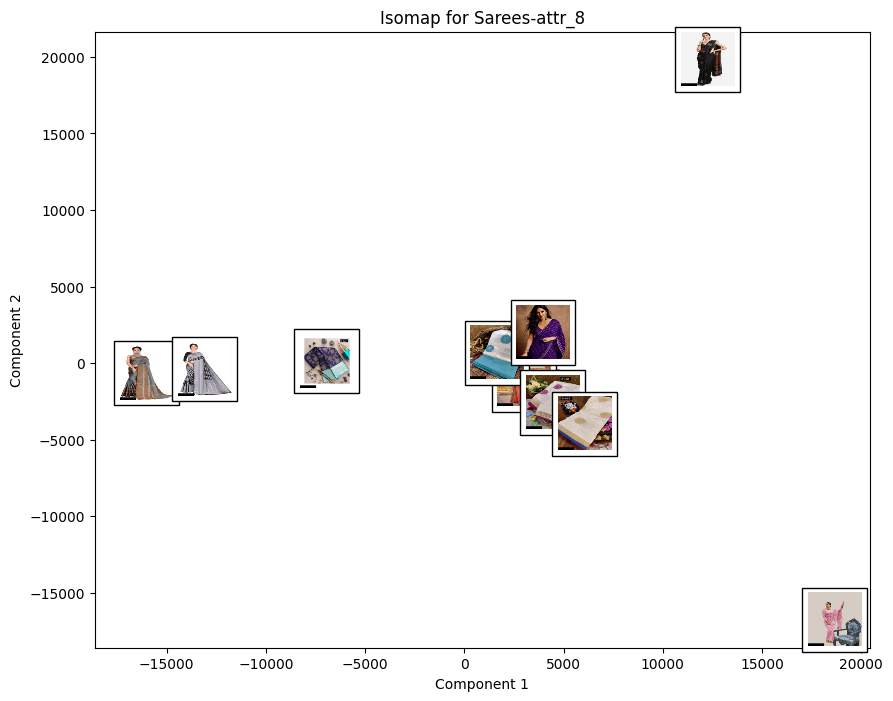

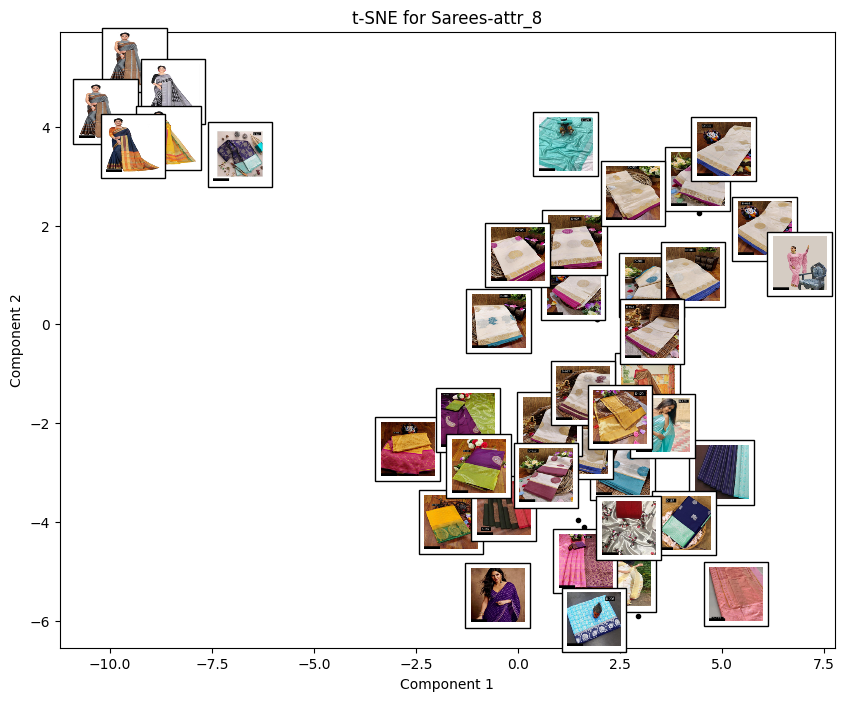

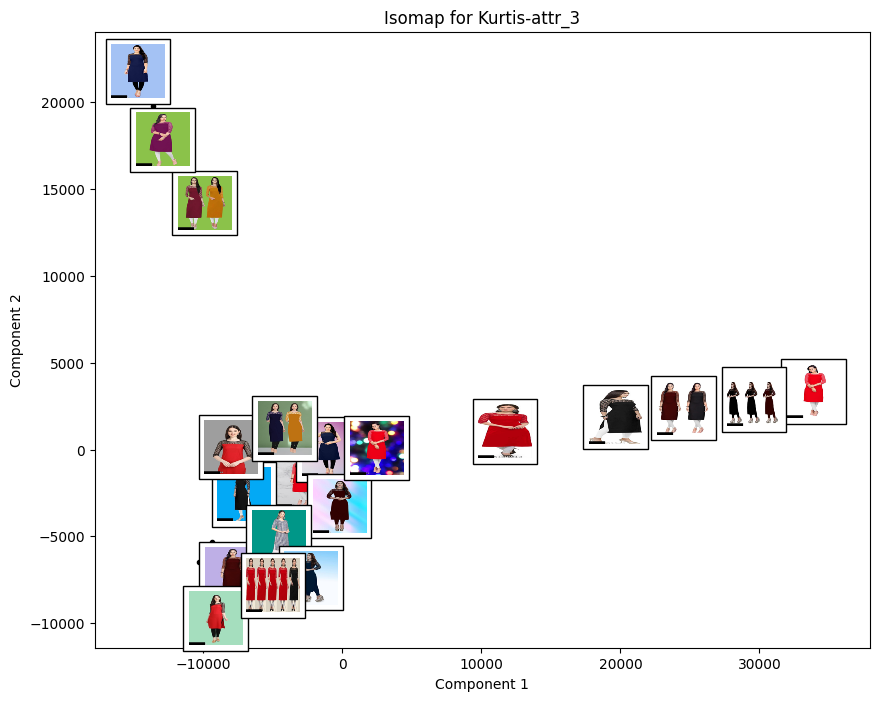

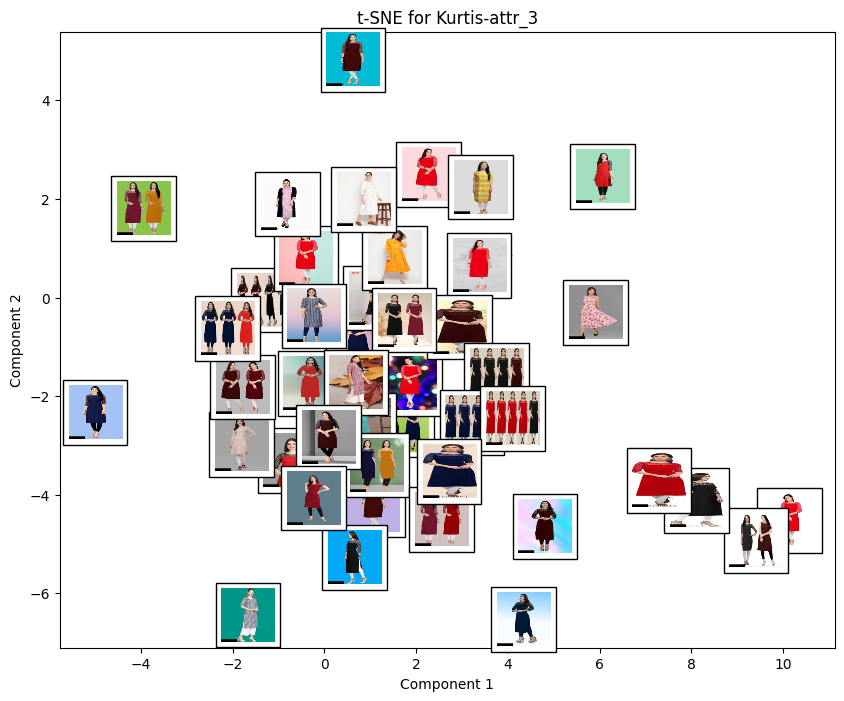

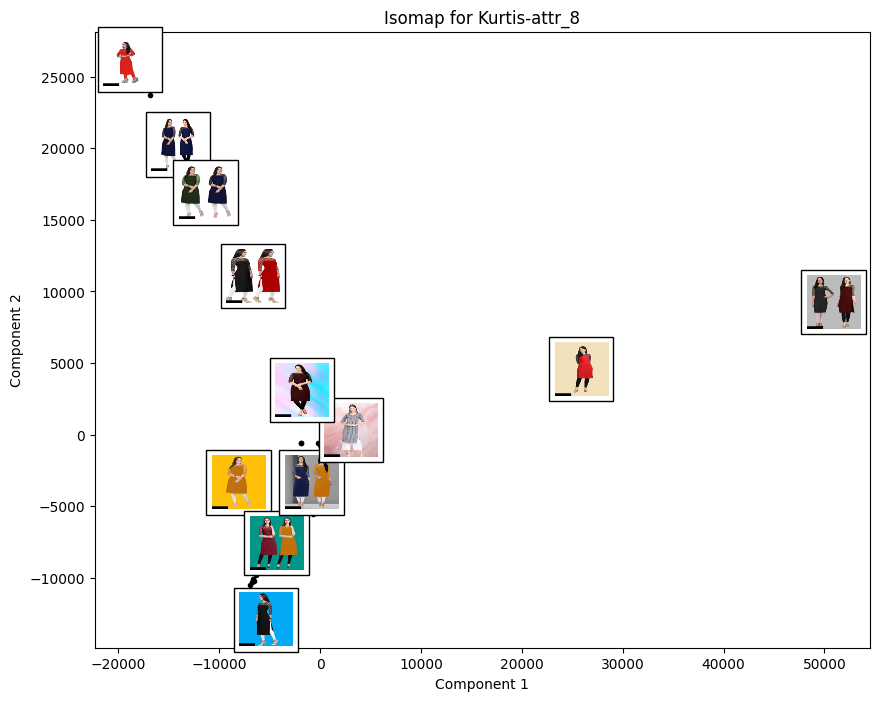

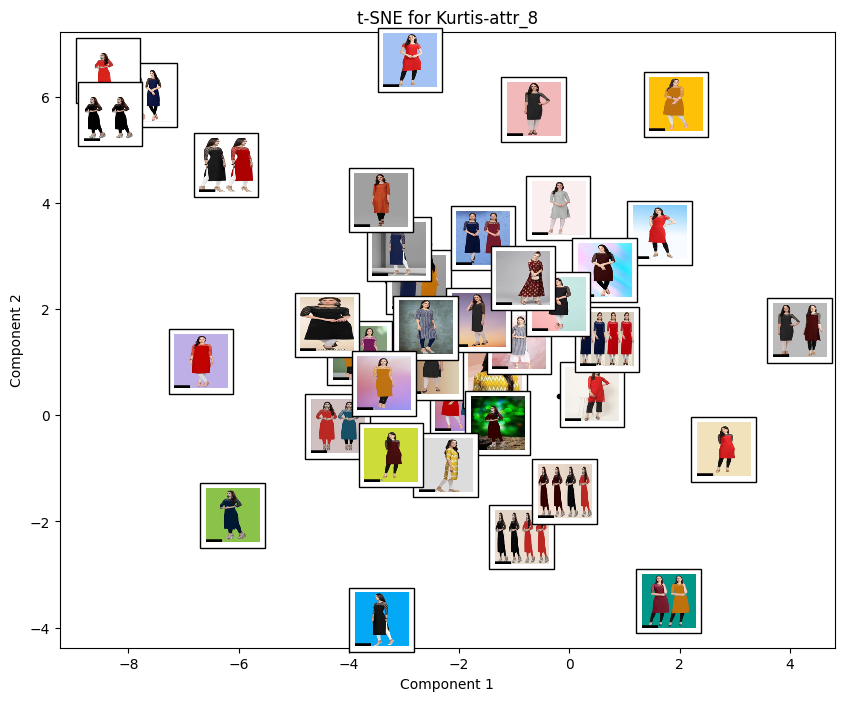

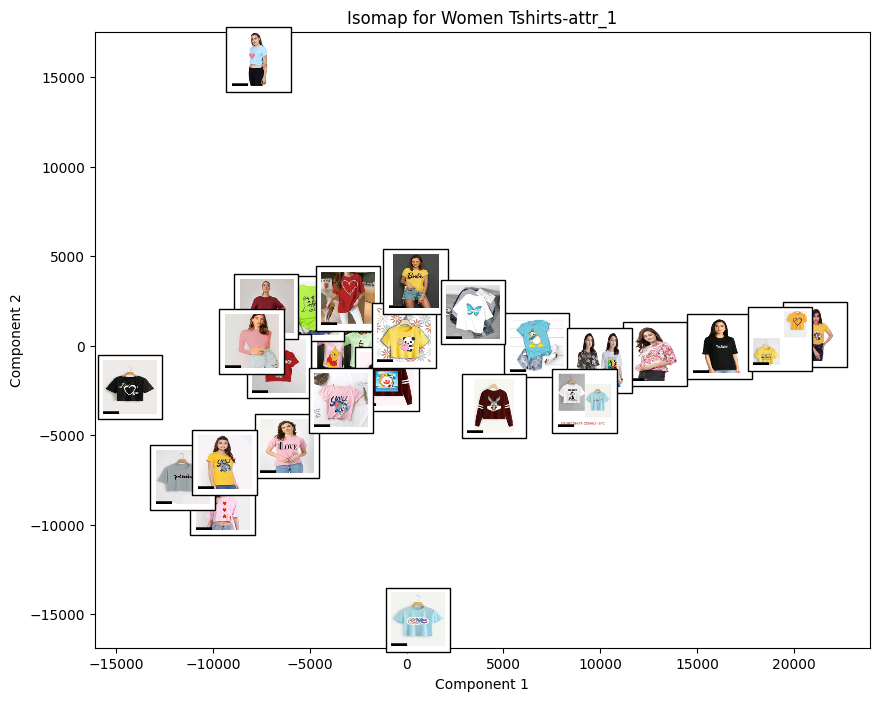

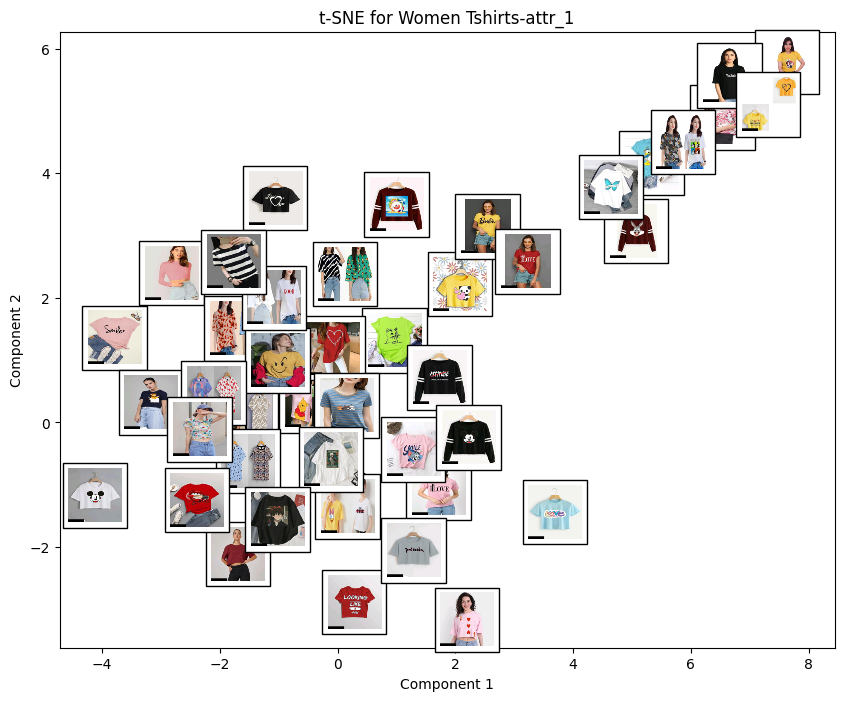

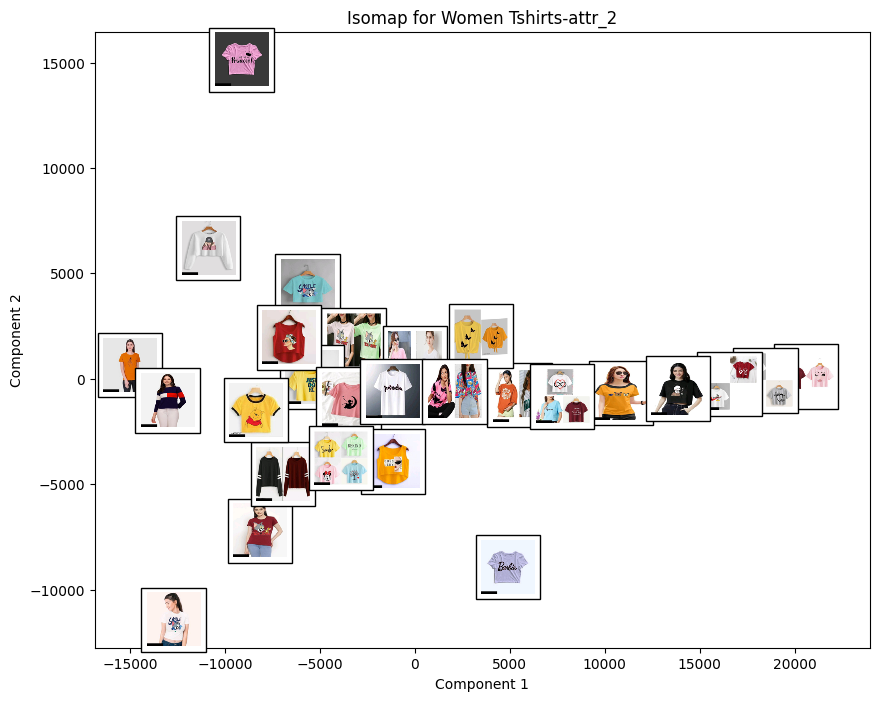

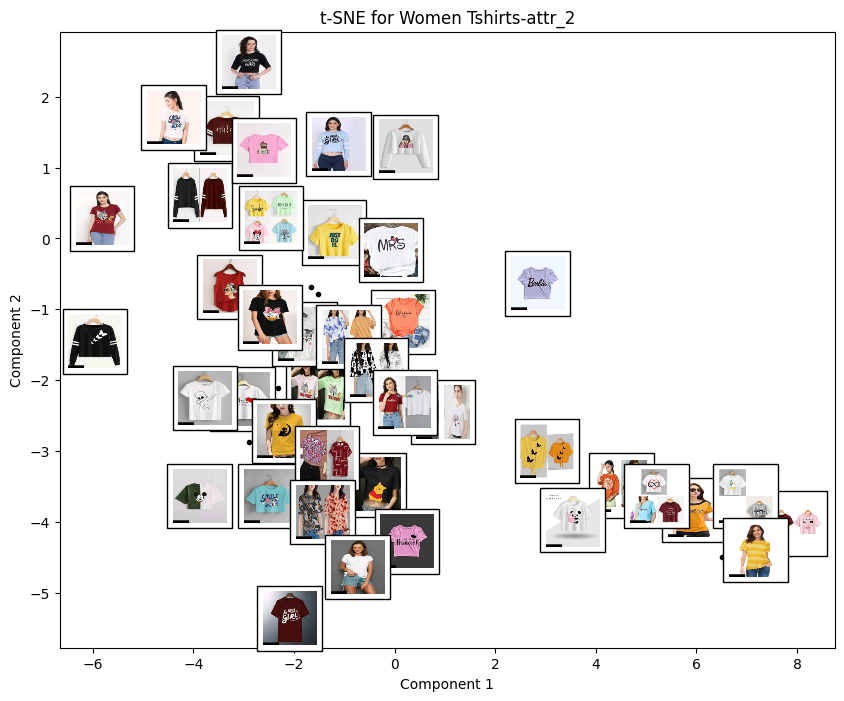

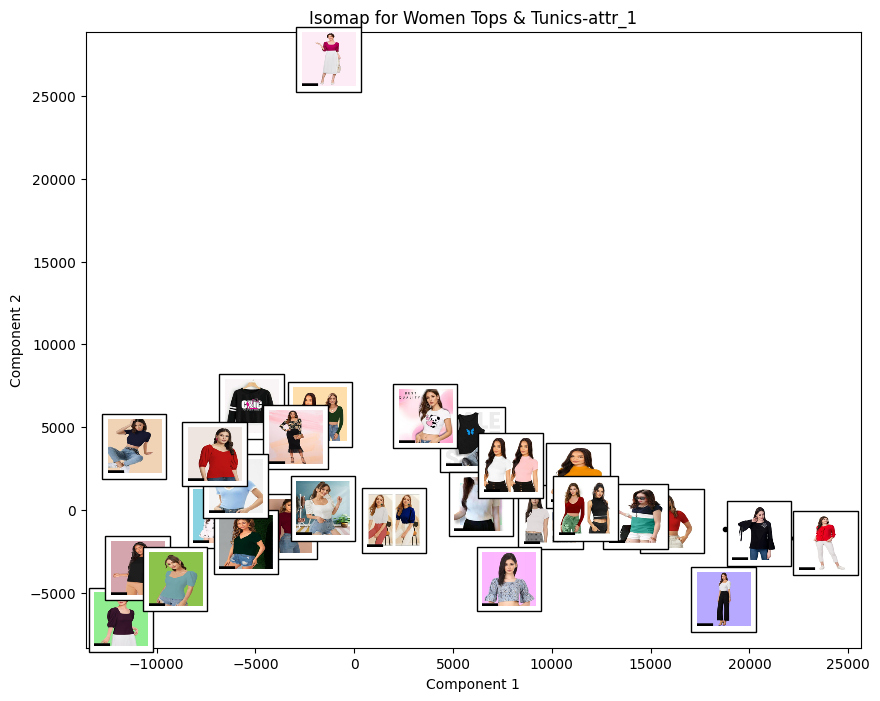

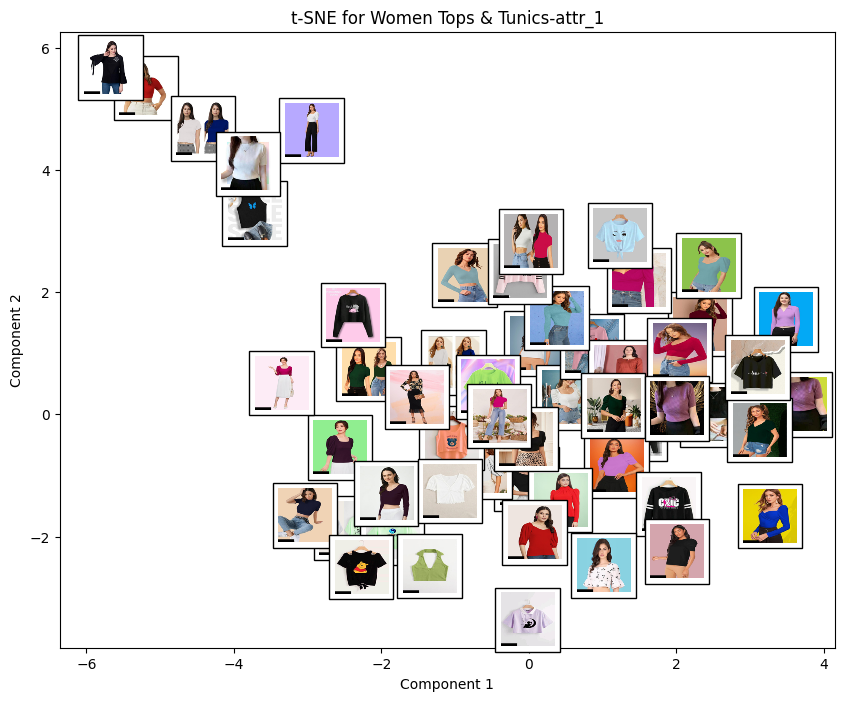

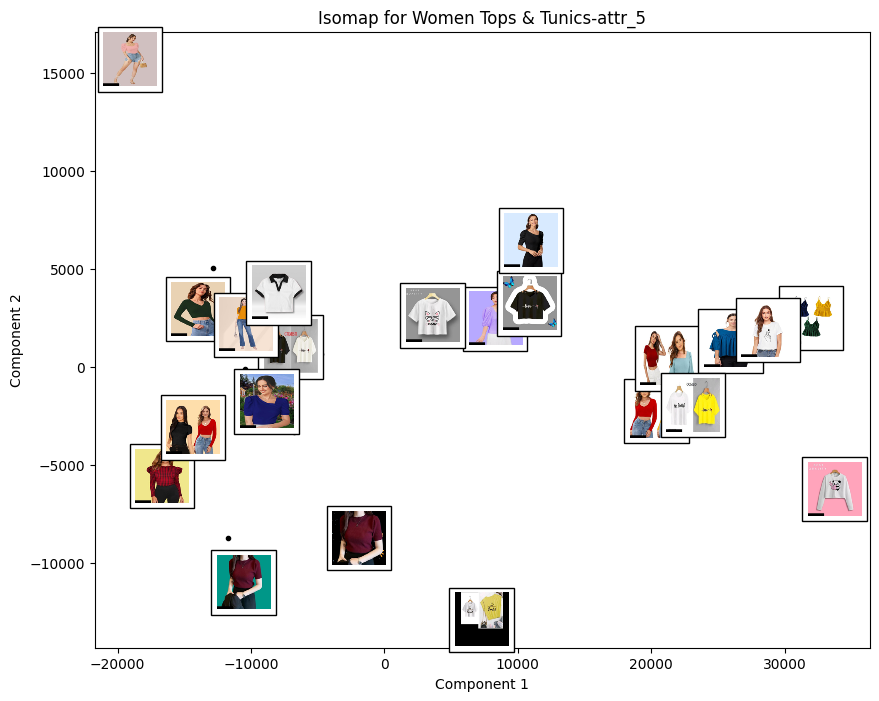

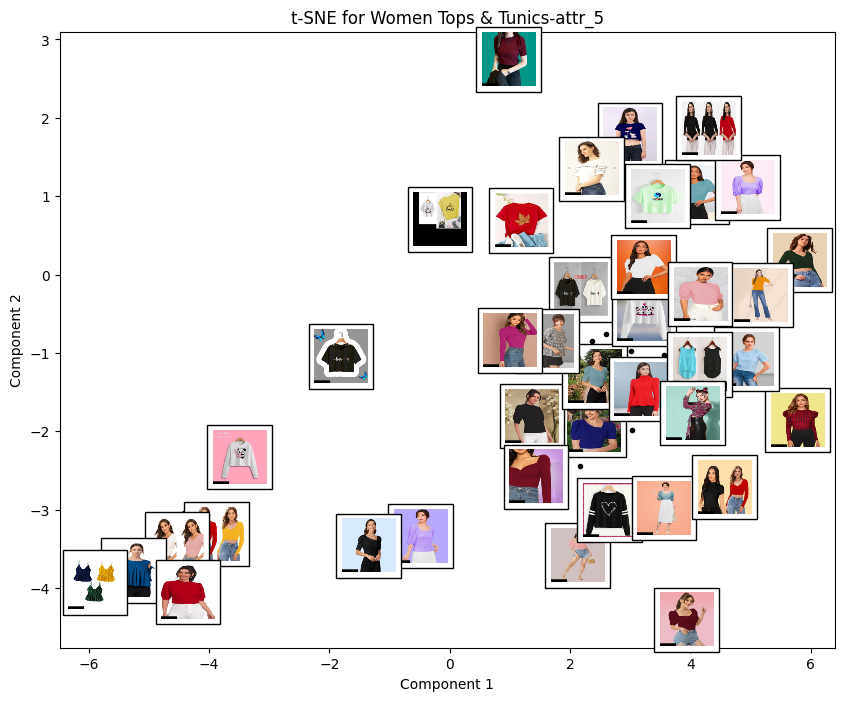

In [16]:
# Perform manifold learning and visualize with images
for (category, attribute), feature_array in X.items():
    images = resized_images_dict[(category, attribute)]  # Images for current basket

    # Isomap Visualization
    isomap_model = Isomap(n_components=2)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f'Isomap for {category} - {attribute}')
    plot_components(feature_array, isomap_model, images=images, ax=ax)

    # t-SNE Visualization
    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f't-SNE for {category} - {attribute}')
    plot_components(feature_array, tsne_model, images=images, ax=ax)

plt.show()

C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


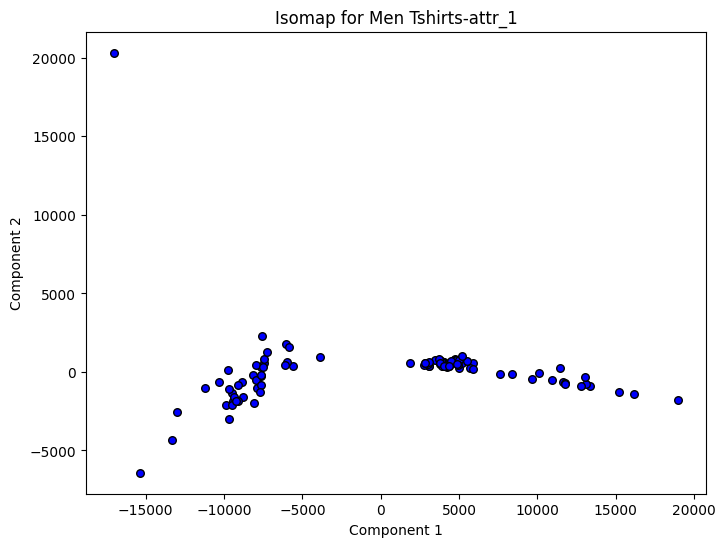

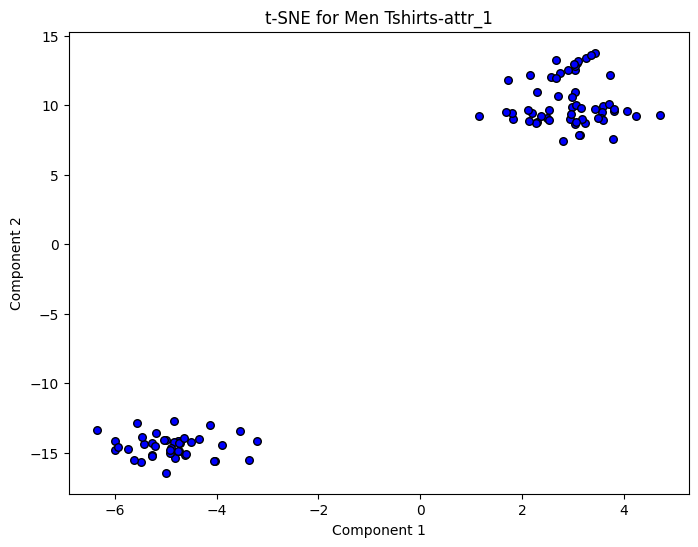

C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


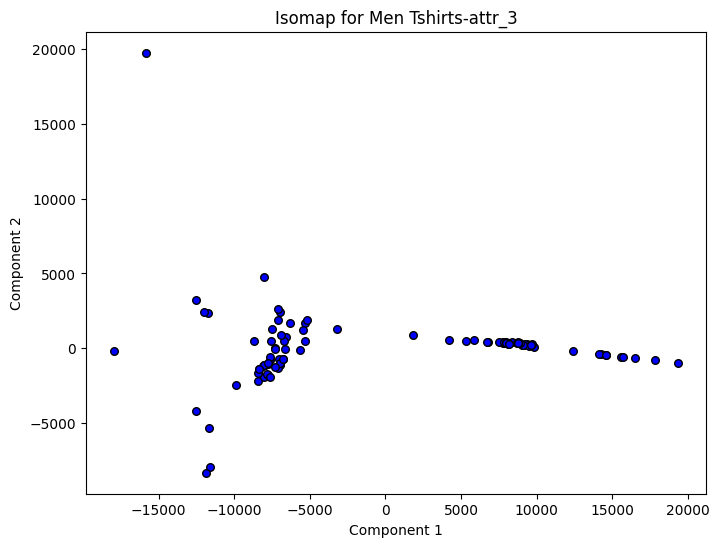

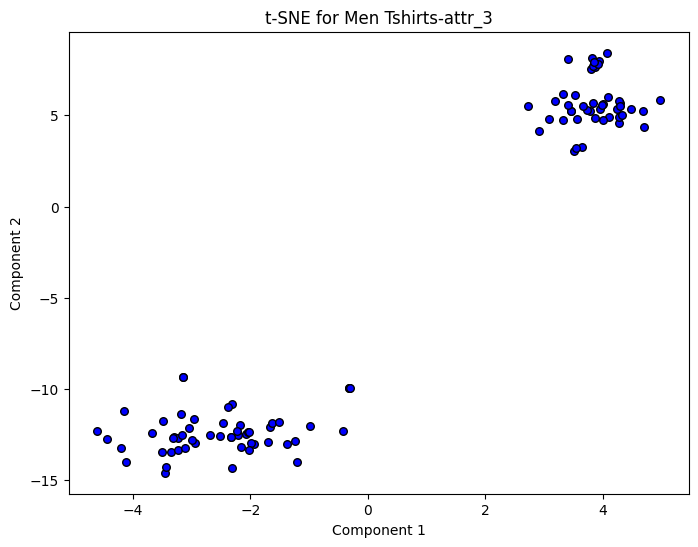

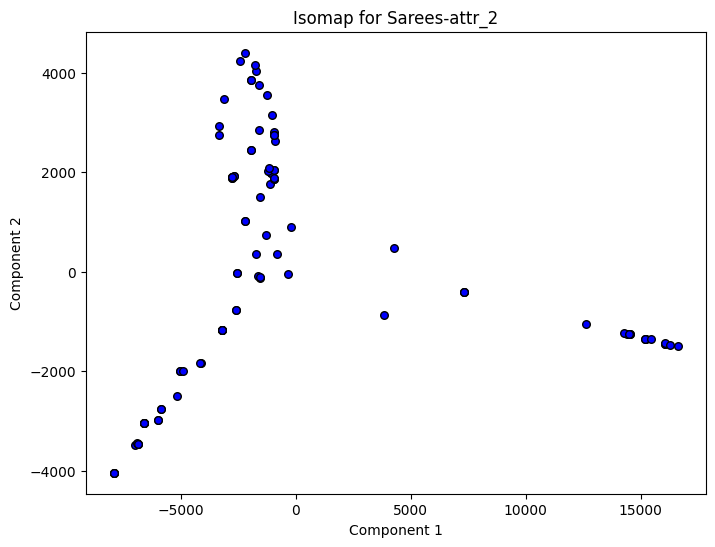

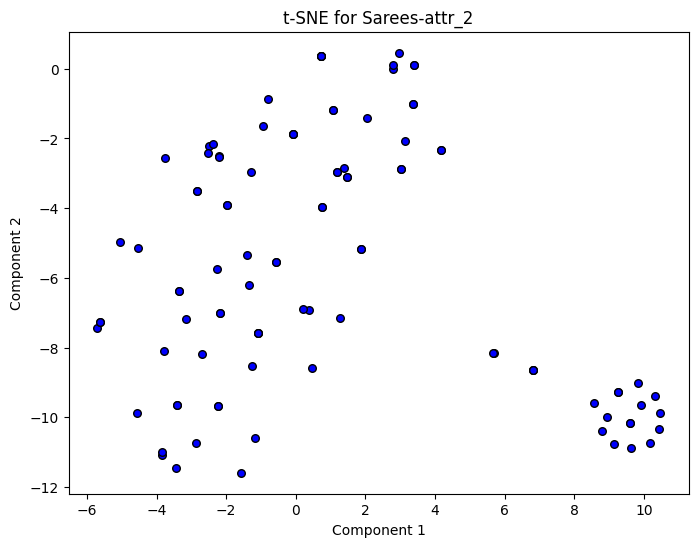

C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\himan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


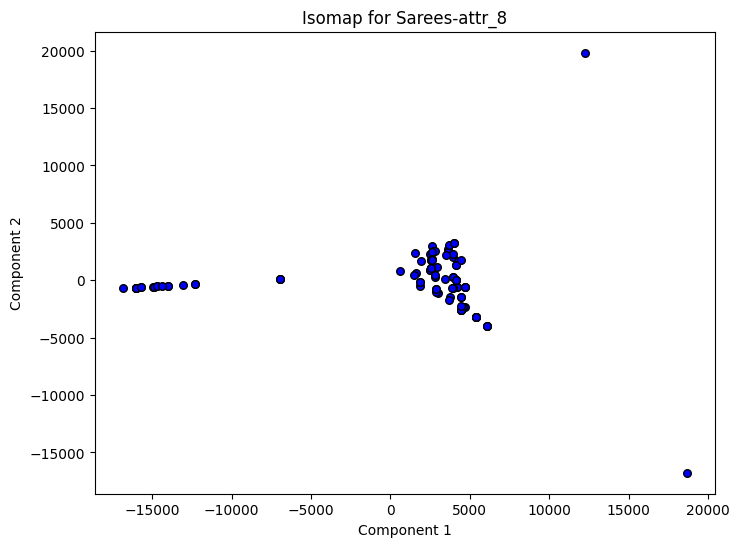

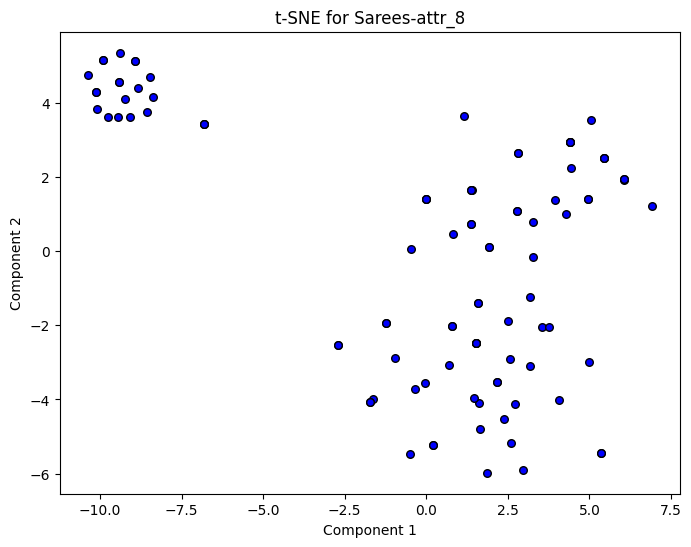

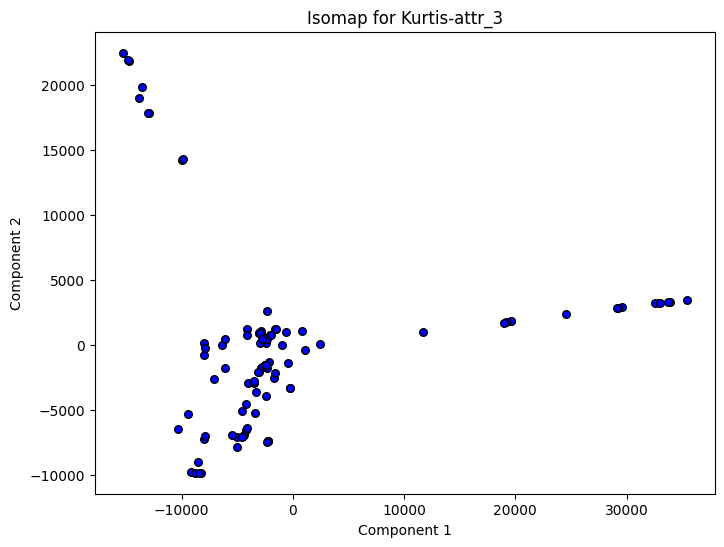

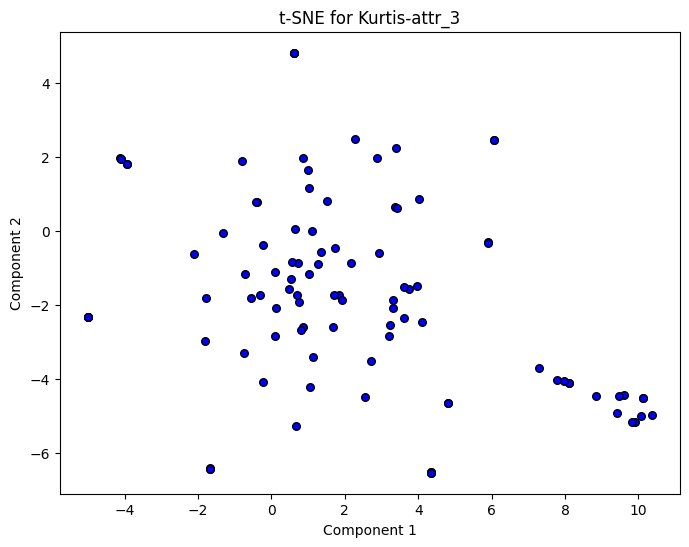

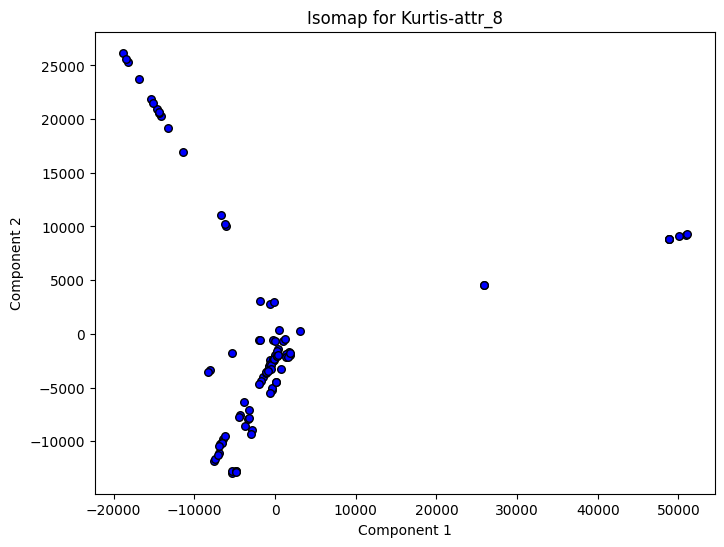

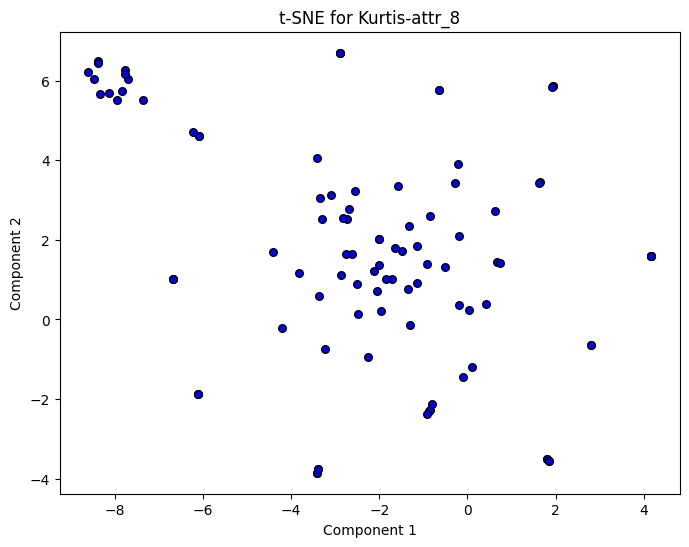

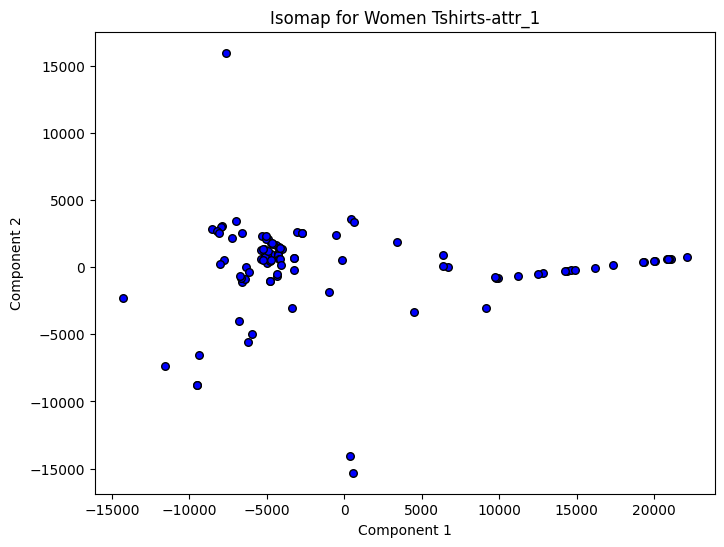

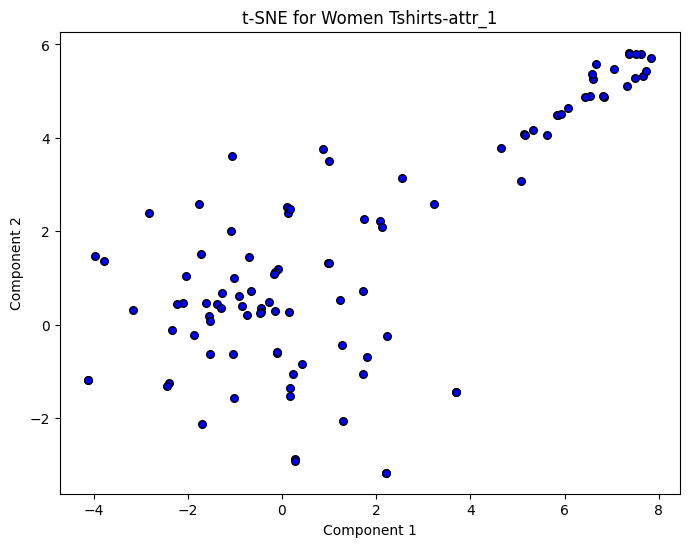

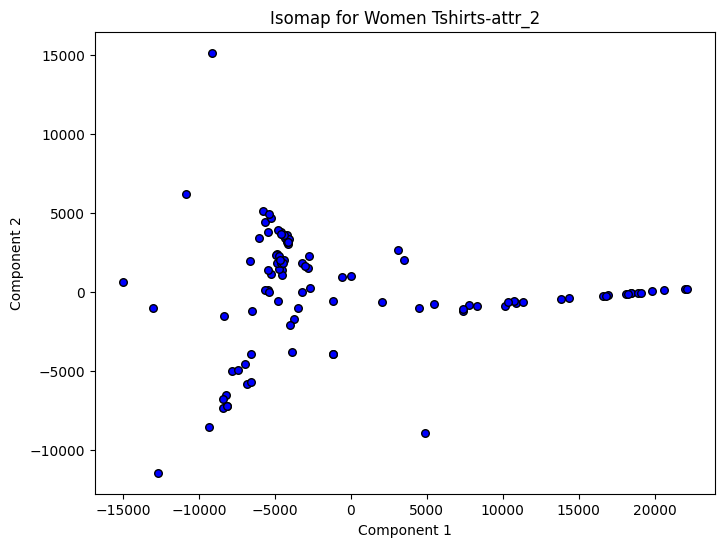

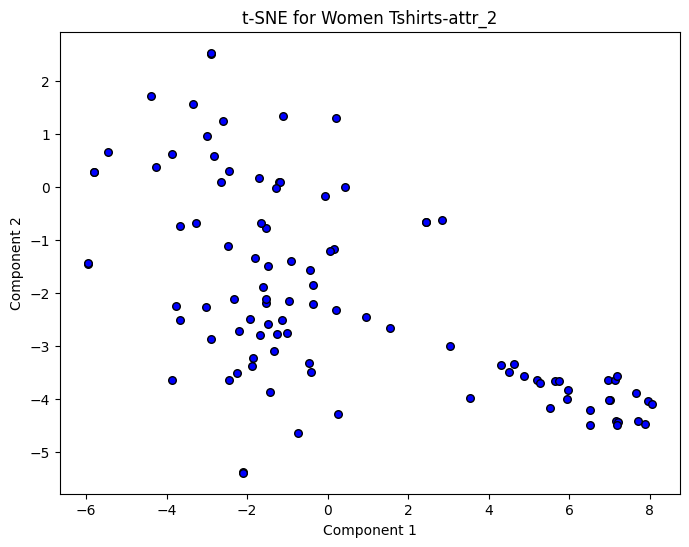

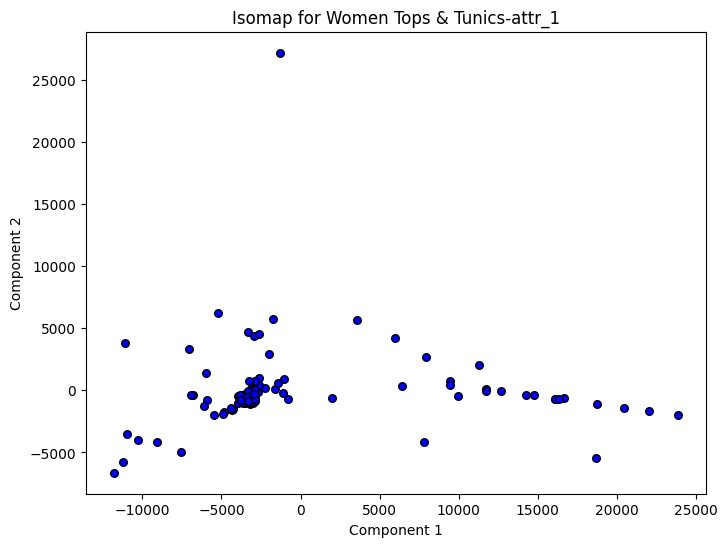

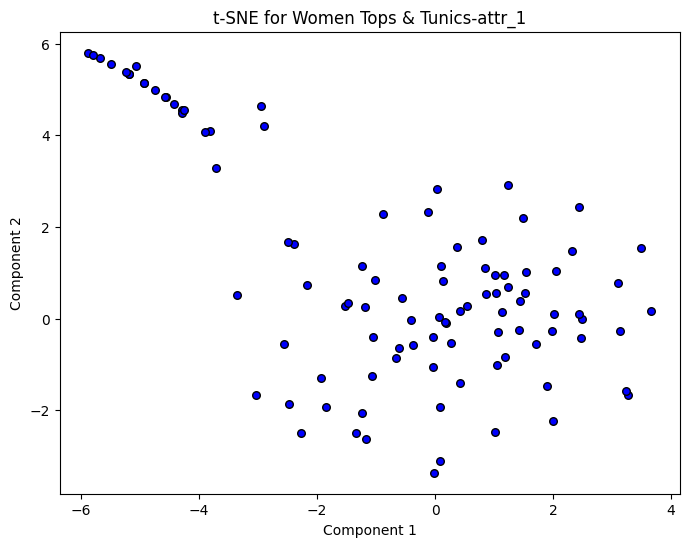

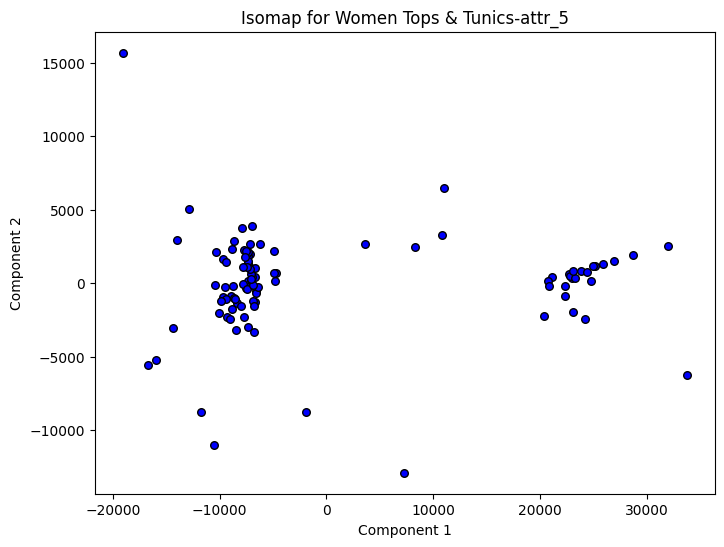

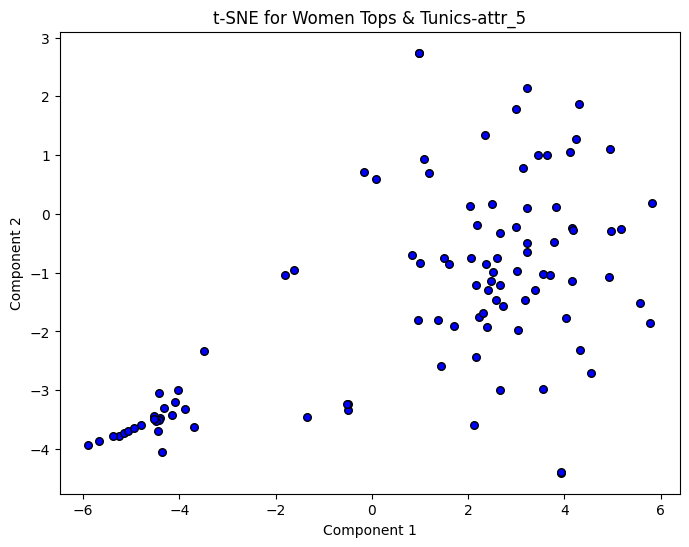

In [9]:
import numpy as np
from sklearn.manifold import Isomap, TSNE
import matplotlib.pyplot as plt

# Initialize `feature_dict` as a dictionary to store features for each (category, attribute)
feature_dict = {}

for (category, attribute), images in resized_images_dict.items():
    # Extract color histogram features for each image
    feature_list = [extract_color_histogram(img) for img in images]
    feature_dict[(category, attribute)] = np.array(feature_list)

# Define the plotting function
def plot_manifold(transformed_features, method, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c='b', edgecolor='k', s=30)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Apply Isomap and t-SNE for each (category, attribute) in feature_dict
for (category, attribute), features in feature_dict.items():
    # Isomap
    isomap_model = Isomap(n_components=2)
    X_isomap = isomap_model.fit_transform(features)
    plot_manifold(X_isomap, isomap_model, f'Isomap for {category} - {attribute}')

    # t-SNE
    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne_model.fit_transform(features)
    plot_manifold(X_tsne, tsne_model, f't-SNE for {category} - {attribute}')

In [8]:
for key, basket in baskets.items():
    print(f"{key}: {len(basket)} samples")

('Men Tshirts', 'attr_1'): 100 samples
('Men Tshirts', 'attr_3'): 100 samples
('Sarees', 'attr_2'): 100 samples
('Sarees', 'attr_8'): 100 samples
('Kurtis', 'attr_3'): 100 samples
('Kurtis', 'attr_8'): 100 samples
('Women Tshirts', 'attr_1'): 100 samples
('Women Tshirts', 'attr_2'): 100 samples
('Women Tops & Tunics', 'attr_1'): 100 samples
('Women Tops & Tunics', 'attr_5'): 100 samples


In [9]:
baskets[('Men Tshirts', 'attr_3')]

id  image_id     Category  len      attr_1 attr_2   attr_3   attr_4  \
6408  6411      6411  Men Tshirts    5       black    NaN  printed      NaN   
2879  2879      2879  Men Tshirts    5       black  round  printed  default   
664    664       664  Men Tshirts    5     default   polo    solid    solid   
1664  1664      1664  Men Tshirts    5     default   polo    solid    solid   
57      57        57  Men Tshirts    5     default   polo    solid    solid   
...    ...       ...          ...  ...         ...    ...      ...      ...   
3788  3788      3788  Men Tshirts    5  multicolor   polo    solid    solid   
2655  2655      2655  Men Tshirts    5  multicolor   polo    solid    solid   
5858  5858      5858  Men Tshirts    5         NaN    NaN  printed  default   
2076  2076      2076  Men Tshirts    5       white  round  printed  default   
2163  2163      2163  Men Tshirts    5  multicolor  round  printed  default   

             attr_5 attr_6 attr_7 attr_8 attr_9 attr_10  Unnamed: 14  \
6408            NaN    NaN    NaN    NaN    NaN     NaN          NaN   
2879   long sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
664   short sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
1664  short sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
57    short sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
...             ...    ...    ...    ...    ...     ...          ...   
3788  short sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
2655  short sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
5858  short sleeves    NaN    NaN    NaN    NaN     NaN          NaN   
2076            NaN    NaN    NaN    NaN    NaN     NaN          NaN   
2163   long sleeves    NaN    NaN    NaN    NaN     NaN          NaN   

      Unnamed: 15  Unnamed: 16  Unnamed: 17  No_of_attribute  \
6408          NaN          NaN          NaN                5   
2879          NaN          NaN          NaN                5   
664           NaN          NaN          NaN                5   
1664          NaN          NaN          NaN                5   
57            NaN          NaN          NaN                5   
...           ...          ...          ...              ...   
3788          NaN          NaN          NaN                5   
2655          NaN          NaN          NaN                5   
5858          NaN          NaN          NaN                5   
2076          NaN          NaN          NaN                5   
2163          NaN          NaN          NaN                5   

                                         Attribute_list  
6408  [color, neck, pattern, print_or_pattern_type, ...  
2879  [color, neck, pattern, print_or_pattern_type, ...  
664   [color, neck, pattern, print_or_pattern_type, ...  
1664  [color, neck, pattern, print_or_pattern_type, ...  
57    [color, neck, pattern, print_or_pattern_type, ...  
...                                                 ...  
3788  [color, neck, pattern, print_or_pattern_type, ...  
2655  [color, neck, pattern, print_or_pattern_type, ...  
5858  [color, neck, pattern, print_or_pattern_type, ...  
2076  [color, neck, pattern, print_or_pattern_type, ...  
2163  [color, neck, pattern, print_or_pattern_type, ...  

[100 rows x 20 columns]

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, TSNE


In [1]:
def plot_manifold(X, method, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='b', edgecolor='k', s=30)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()